In [ ]:
# https://wikidocs.net/195317 

In [8]:
import numpy as np
import pandas as pd


import matplotlib.pyplot as plt
import seaborn as sns

import glob
import joblib

import librosa
import IPython.display as ipd


In [9]:
import glob

root = '/kaggle/input/free-spoken-digits/free-spoken-digit-dataset-master/recordings/'
# recordings_dir = '/kaggle/input/free-spoken-digits/free-spoken-digit-dataset-master/recordings/'
files = sorted(glob.glob(root + '**/*.wav', recursive=True))
print(len(files))
print(files[0])


3000
/kaggle/input/free-spoken-digits/free-spoken-digit-dataset-master/recordings/0_george_0.wav


data length: 11075, sampling rate: 22050
data length: 10000, [4608 8704]


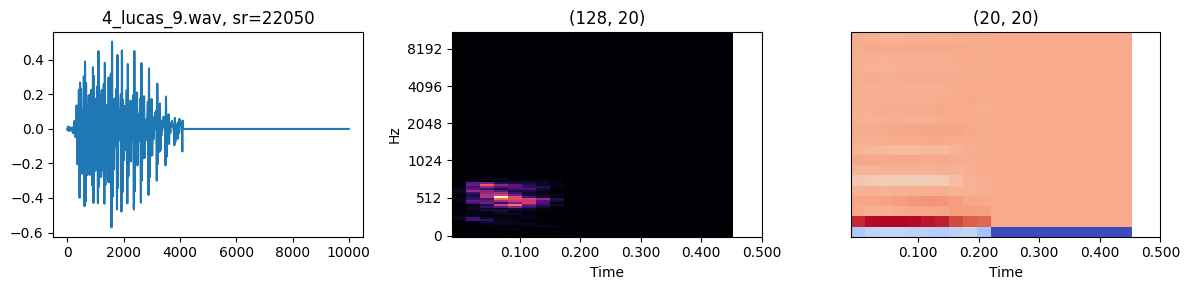

data length: 9813, sampling rate: 22050
data length: 10000, [3072 7680]


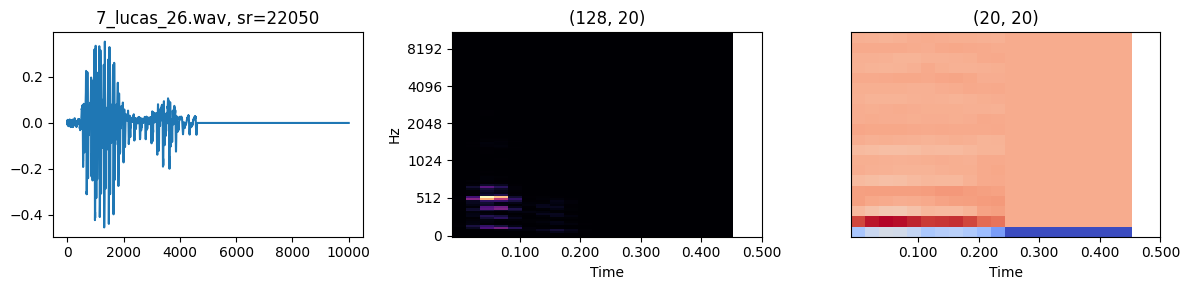

data length: 13592, sampling rate: 22050
data length: 10000, [ 2560 10240]


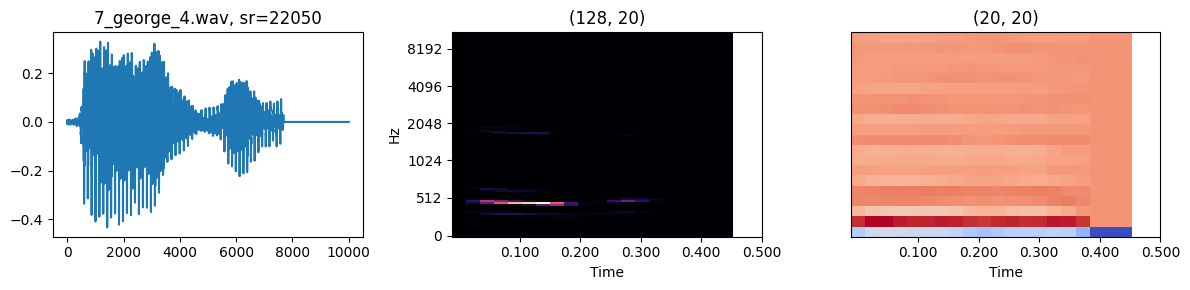

data length: 7109, sampling rate: 22050
data length: 10000, [   0 5120]


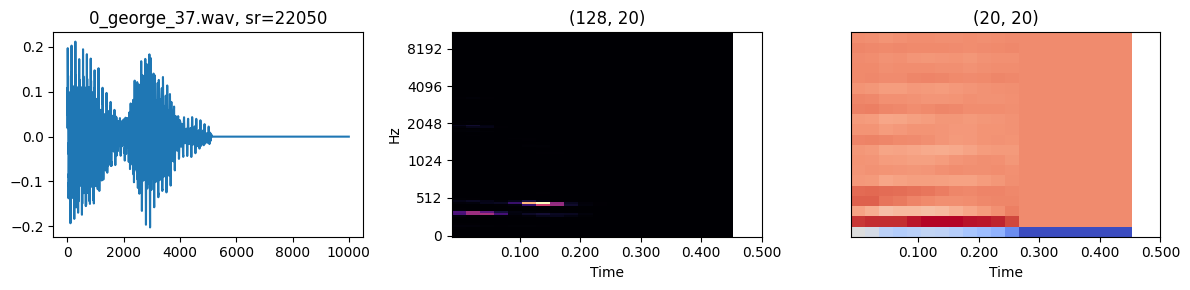

data length: 8628, sampling rate: 22050
data length: 10000, [1024 7680]


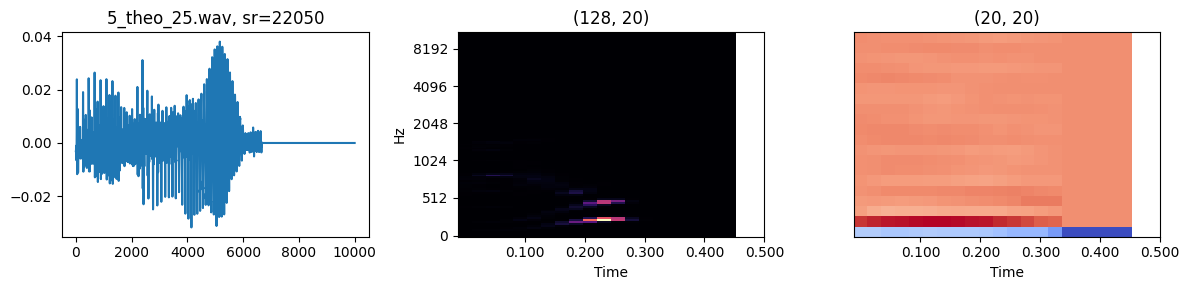

data length: 11290, sampling rate: 22050
data length: 10000, [ 1024 11264]


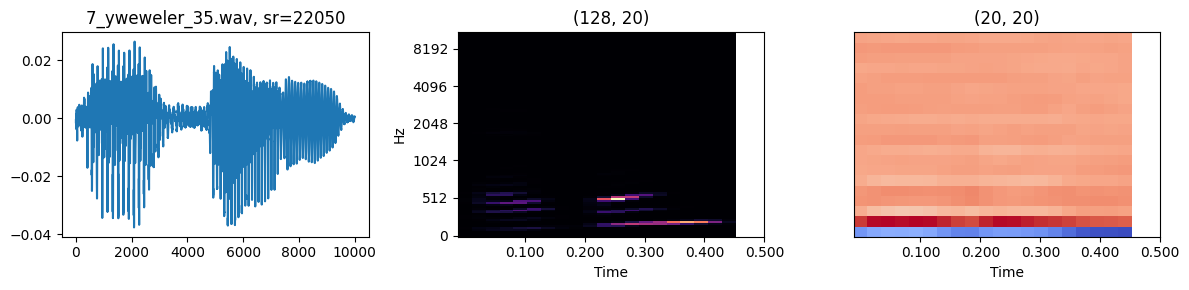

data length: 11348, sampling rate: 22050
data length: 10000, [3072 9728]


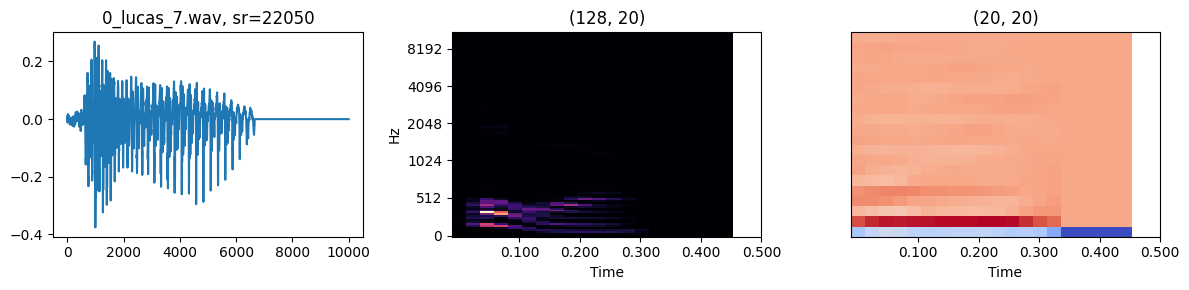

data length: 8096, sampling rate: 22050
data length: 10000, [ 512 6144]


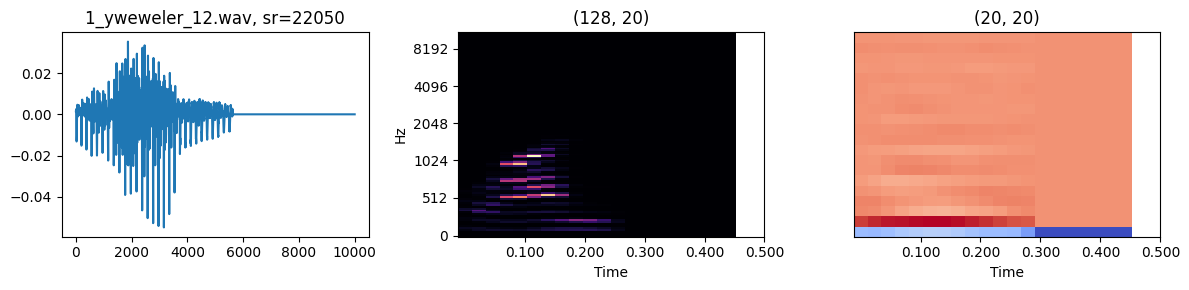

data length: 10386, sampling rate: 22050
data length: 10000, [ 512 4608]


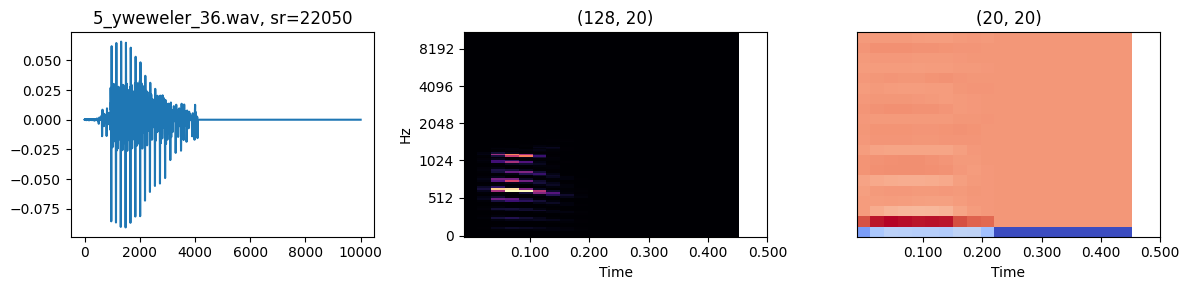

data length: 7429, sampling rate: 22050
data length: 10000, [   0 6144]


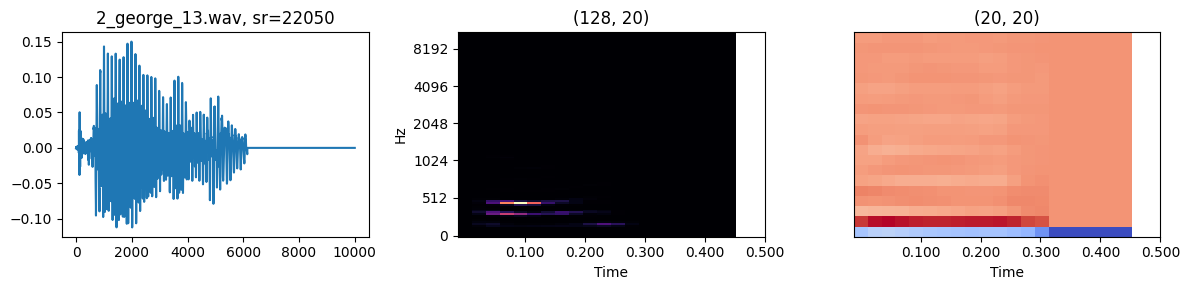

In [10]:
def wav_info(file, trim=False):
    data,sr = librosa.load(file)
    print(f"data length: {len(data)}, sampling rate: {sr}")
    if trim :
        data, area = librosa.effects.trim(data, top_db=10)
        data = librosa.util.fix_length(data, size=10000)
        print(f"data length: {len(data)}, {area}")

    ipd.display(ipd.Audio(data, rate=sr))

    fig,ax = plt.subplots(1,3,figsize=(12,3))
    ax[0].plot(data)
    ax[0].set_title(f"{file.split('/')[-1]}, sr={sr}")

    mel = librosa.feature.melspectrogram(y=data, sr=sr)
    librosa.display.specshow(mel, x_axis='time', y_axis='mel', ax=ax[1])
    ax[1].set_title(f"{mel.shape}")
    ax[1].set_xticks([0.1, 0.2, 0.3, 0.4, 0.5])

    mfcc = librosa.feature.mfcc(y=data, sr=sr)
    librosa.display.specshow(mfcc, x_axis='time', ax=ax[2])
    ax[2].set_xticks([0.1, 0.2, 0.3, 0.4, 0.5])    
    ax[2].set_title(f"{mfcc.shape}")

    plt.tight_layout() 
    plt.show()

num = np.random.randint(0,3000,10)
for file in np.array(files)[num]:
    wav_info(file, trim=True)

In [23]:
%%time
import joblib as jl

def make_dataset(file, trim=True):
    dataset = []
    data,sr = librosa.load(file)

    if trim :
        data, area = librosa.effects.trim(data, top_db=10)
        data = librosa.util.fix_length(data, size=10000)

    mel = librosa.feature.melspectrogram(y=data, sr=sr)
    mfcc = librosa.feature.mfcc(y=data, sr=sr)
    label = file.split('/')[-1].split('_')[0]
    dataset.append([mel, mfcc, label])
    return dataset

dataset = jl.Parallel(n_jobs=-1)(jl.delayed(make_dataset)(x) for x in files)

CPU times: user 1.12 s, sys: 80.1 ms, total: 1.2 s
Wall time: 11.6 s


In [21]:
df_ds = pd.DataFrame(np.array(dataset, dtype=object).squeeze(), columns=['mel','mfcc','label'])


In [22]:
x_mel = np.array(df_ds.mel.to_list())
x_mfcc = np.array(df_ds.mfcc.to_list())
y = np.array(df_ds.label.astype(int))
print(x_mel.shape, x_mfcc.shape, y.shape)

(3000, 128, 40) (3000, 20, 40) (3000,)


In [18]:
from sklearn.model_selection import train_test_split

x_train,x_test,y_train,y_test = train_test_split(x_mel,y,test_size=0.2,stratify=y,
                                                 shuffle=True, random_state=42)
print(x_train.shape, x_test.shape, y_train.shape, y_test.shape)

(2400, 128, 20) (600, 128, 20) (2400,) (600,)


In [19]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, Dense, MaxPool1D, Flatten
import keras.backend as K
K.clear_session()

model_mel = Sequential([
    Conv1D(32, 3, activation='relu', input_shape=(128,20)),
    MaxPool1D(2),
    Conv1D(64, 3, activation='relu'),
    MaxPool1D(2),
    Flatten(),
    Dense(100, activation='relu'),
    Dense(10, activation='softmax')
])

model_mel.compile(loss='sparse_categorical_crossentropy',
                 metrics=['accuracy'], optimizer='adam')
model_mel.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 126, 32)           1952      
                                                                 
 max_pooling1d (MaxPooling1  (None, 63, 32)            0         
 D)                                                              
                                                                 
 conv1d_1 (Conv1D)           (None, 61, 64)            6208      
                                                                 
 max_pooling1d_1 (MaxPoolin  (None, 30, 64)            0         
 g1D)                                                            
                                                                 
 flatten (Flatten)           (None, 1920)              0         
                                                                 
 dense (Dense)               (None, 100)               1

In [24]:
# %%time
from sklearn.model_selection import KFold
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping,\
                                        ReduceLROnPlateau,CSVLogger

model = model_mel
kfold = KFold(n_splits=5, shuffle=True, random_state=42)
for i, (trn_idx,val_idx) in enumerate(kfold.split(x_train)):
    print(f"Fold {i}")

    x_trn,y_trn = x_train[trn_idx],y_train[trn_idx]
    x_val,y_val = x_train[val_idx],y_train[val_idx]

    mc = ModelCheckpoint(filepath=f'mel_w_{i}.h5', save_weight_only=True,
                        verbose=0, save_best_only=True)
    es = EarlyStopping(monitor='val_loss', patience=20, verbose=1,
                      restore_best_weights=True)
    rlr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=10,
                            verbose=1, min_lr=1e-6)
    cl = CSVLogger('mel.log')

    history = model.fit(x_trn,y_trn, validation_data=(x_val,y_val),
                       epochs=100, batch_size=32, verbose=0, workers=-1,
                       callbacks=[cl,mc,es,rlr])

    model.evaluate(x_test,y_test)


Fold 0


/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(



Epoch 32: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
Restoring model weights from the end of the best epoch: 22.

Epoch 42: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.
Epoch 42: early stopping
19/19 [==============================] - 0s 4ms/step - loss: 0.3898 - accuracy: 0.9200
Fold 1
19/19 [==============================] - 0s 4ms/step - loss: 0.3864 - accuracy: 0.9317
Fold 2

Epoch 100: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-06.
19/19 [==============================] - 0s 5ms/step - loss: 0.4779 - accuracy: 0.9300
Fold 3

Epoch 11: ReduceLROnPlateau reducing learning rate to 1e-06.
Restoring model weights from the end of the best epoch: 1.
Epoch 21: early stopping
19/19 [==============================] - 0s 5ms/step - loss: 0.4781 - accuracy: 0.9317
Fold 4
Restoring model weights from the end of the best epoch: 1.
Epoch 21: early stopping
19/19 [==============================] - 0s 5ms/step - loss: 0.4781 - a

In [25]:
from sklearn.metrics import classification_report, confusion_matrix

def pred_list(name):
    pred_list=[]
    for i in range(5):
        model.load_weights(f"{name}_w_{i}.h5")
        model.evaluate(x_test,y_test)
        pred = model.predict(x_test)
        pred_list.append(pred)
    return pred_list
model = model_mel
pred_list_mel = pred_list('mel')

19/19 [==============================] - 0s 5ms/step


In [27]:
pred_mel = np.sum(np.array(pred_list_mel), axis=0)
pred_y = np.argmax(pred_mel, axis=1)

print(classification_report(y_test, pred_y))
print(confusion_matrix(y_test, pred_y))

              precision    recall  f1-score   support

           0       0.88      0.95      0.91        60
           1       0.95      0.93      0.94        60
           2       0.93      0.90      0.92        60
           3       0.88      0.85      0.86        60
           4       0.94      0.98      0.96        60
           5       0.97      0.97      0.97        60
           6       0.88      0.93      0.90        60
           7       0.95      0.95      0.95        60
           8       0.98      0.87      0.92        60
           9       0.97      0.97      0.97        60

    accuracy                           0.93       600
   macro avg       0.93      0.93      0.93       600
weighted avg       0.93      0.93      0.93       600

[[57  0  1  2  0  0  0  0  0  0]
 [ 0 56  0  0  1  2  0  0  0  1]
 [ 0  0 54  4  1  0  1  0  0  0]
 [ 5  0  2 51  0  0  1  0  1  0]
 [ 0  1  0  0 59  0  0  0  0  0]
 [ 0  0  0  0  1 58  0  0  0  1]
 [ 1  0  1  1  0  0 56  1  0  0]
 [ 1  0  0